In [6]:
%pip install boto3

In [9]:
import os
import sys
import random
from io import BytesIO
from datetime import datetime
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms as T
from torchvision.transforms import functional as TF

import cv2
from PIL import Image

import boto3
from botocore.config import Config
import gdown

from herdnet import HerdNet
from utils import LossWrapper, load_model
from focal import FocalLoss




AWS_ACCESS_KEY_ID=""
AWS_SECRET_ACCESS_KEY=""
S3_BUCKET=""
SAMPLE_RESPONSE='{"url": "", "inference": [  {"class_id": 0, "class_name": "Clase 0", "count": 15, "avg_confidence": 2.03},  {"class_id": 2, "class_name": "Clase 2", "count": 107, "avg_confidence": 5.34},  {"class_id": 4, "class_name": "Clase 4", "count": 29, "avg_confidence": 4.13},  {"class_id": 5, "class_name": "Clase 5", "count": 9, "avg_confidence": 1.88}]}'




In [10]:
gdown.download(
        'https://drive.google.com/uc?export=download&id=1-WUnBC4BJMVkNvRqalF_HzA1_pRkQTI_',
        '/content/20220413_herdnet_model.pth'
        )
pth_path = '/content/20220413_herdnet_model.pth'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1-WUnBC4BJMVkNvRqalF_HzA1_pRkQTI_
From (redirected): https://drive.google.com/uc?export=download&id=1-WUnBC4BJMVkNvRqalF_HzA1_pRkQTI_&confirm=t&uuid=896e1237-0a7a-46b2-a211-2c5ae1631c2b
To: /content/20220413_herdnet_model.pth
100%|██████████| 220M/220M [00:02<00:00, 81.2MB/s]


In [24]:
def upload_image_to_s3(img_pred, region="us-east-2"):
    """
    Recibe como el Numpy array de la imagen inferida.
    Retorna la URL de la imagen publicada en S3
    """
    now = datetime.now()
    filename = now.strftime("%Y-%m-%d_%H-%M-%S")

    image = Image.fromarray(img_pred)
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    buffer.seek(0)

    object_key = f"processed/inference_{filename}.jpg"

    s3 = boto3.client(
        "s3",
        region_name=region,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        config=Config(signature_version="s3v4")
    )

    s3.upload_fileobj(
        buffer,
        S3_BUCKET,
        object_key,
        ExtraArgs={'ContentType': 'image/jpeg'}
    )

    url = f"https://{S3_BUCKET}.s3.{region}.amazonaws.com/{object_key}"
    return url


def summarize_predictions(pred_classes, class_confidences, class_names, num_classes):
    result = []
    for cls in range(num_classes):
        count = sum(1 for c in pred_classes if c == cls)
        if count > 0:
            avg_conf = np.mean([
                conf for c, conf in zip(pred_classes, class_confidences) if c == cls
            ])
            result.append({
                "class_id": cls,
                "class_name": class_names.get(cls, f"Clase {cls}"),
                "count": count,
                "avg_confidence": round(float(avg_conf), 2)
            })
    return result



def predictImage(pil_img):
    """
    image: Es una imagen en bytes
    """

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


    pth_path = '20220413_herdnet_model.pth'
    num_classes = 7
    down_ratio = 2
    herdnet = HerdNet(num_classes=num_classes, down_ratio=down_ratio, pretrained=False).cuda()

    weight = Tensor([0.1, 1.0, 2.0, 1.0, 6.0, 12.0, 1.0]).cuda()

    losses = [
        {'loss': FocalLoss(reduction='mean'), 'idx': 0, 'idy': 0, 'lambda': 1.0, 'name': 'focal_loss'},
        {'loss': CrossEntropyLoss(reduction='mean', weight=weight), 'idx': 1, 'idy': 1, 'lambda': 1.0, 'name': 'ce_loss'}
    ]

    herdnet = LossWrapper(herdnet, losses=losses)

    from utils import load_model
    herdnet = load_model(herdnet, pth_path=pth_path)

    num_classes = 7
    down_ratio = 2

    image = "test.JPG"



    def resize_to_nearest_multiple_of_32(pil_image):
        width, height = pil_image.size

        def nearest_multiple(x, base=32):
            return base * round(x / base)

        new_w = nearest_multiple(width)
        new_h = nearest_multiple(height)

        resized = TF.resize(pil_image, (new_h, new_w))
        return T.ToTensor()(resized), new_h, new_w


    image, new_h, new_w = resize_to_nearest_multiple_of_32(pil_img)


    def pad_to_multiple(tensor, multiple):
        C, H, W = tensor.shape
        pad_h = (multiple - H % multiple) % multiple
        pad_w = (multiple - W % multiple) % multiple
        return F.pad(tensor, (0, pad_w, 0, pad_h)), pad_h, pad_w


    image_padded, pad_top, pad_left = pad_to_multiple(image, 32)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).cuda()
    image_norm = (image_padded.cuda() - mean) / std

    herdnet.eval()
    with torch.no_grad():
        input_tensor = image_norm.unsqueeze(0)
        output = herdnet(input_tensor)

    heatmap = output[0][0].squeeze().cpu().numpy()
    class_output = output[0][1].squeeze(0).cpu().numpy()
    threshold = 0.1
    pred_points = np.argwhere(heatmap > threshold)
    print(f"\nMáximo del heatmap: {heatmap.max():.4f}, Total puntos detectados: {len(pred_points)}")

    h_ratio = class_output.shape[1] / heatmap.shape[0]
    w_ratio = class_output.shape[2] / heatmap.shape[1]

    pred_classes = []
    class_confidences = []
    valid_points = []

    for y, x in pred_points:
        y_cls = int(y * h_ratio)
        x_cls = int(x * w_ratio)

        if y_cls < class_output.shape[1] and x_cls < class_output.shape[2]:
            class_probs = class_output[:, y_cls, x_cls]
            pred_class = np.argmax(class_probs)
            confidence = class_probs[pred_class]
            pred_classes.append(pred_class)
            class_confidences.append(confidence)
            valid_points.append([y, x])

    valid_points = np.array(valid_points).reshape(-1, 2)

    pred_points = valid_points * down_ratio

    pred_points[:, 0] -= pad_top
    pred_points[:, 1] -= pad_left
    valid_indices = (pred_points[:, 0] >= 0) & (pred_points[:, 1] >= 0)
    pred_points = pred_points[valid_indices]
    pred_classes = [pred_classes[i] for i in range(len(pred_classes)) if valid_indices[i]]
    class_confidences = [class_confidences[i] for i in range(len(class_confidences)) if valid_indices[i]]

    print(f"Puntos válidos después de filtrar: {len(pred_points)}")

    class_names = {
        0: 'Clase 0',
        1: 'Clase 1',
        2: 'Clase 2',
        3: 'Clase 3',
        4: 'Clase 4',
        5: 'Clase 5',
        6: 'Clase 6'
    }

    class_colors = {
        0: (255, 50, 50),
        1: (50, 255, 50),
        2: (50, 100, 255),
        3: (255, 255, 80),
        4: (255, 80, 255),
        5: (80, 255, 255),
        6: (200, 0, 200)
    }

    orig_img = image.permute(1, 2, 0).cpu().numpy()
    orig_img = np.clip(orig_img * 255, 0, 255).astype(np.uint8)
    img_pred = orig_img.copy()

    for (y, x), cls, conf in zip(pred_points, pred_classes, class_confidences):
        color = class_colors.get(cls, (255, 255, 255))
        cv2.circle(img_pred, (int(x), int(y)), 40, color, -1)
        label = ''
        cv2.putText(img_pred, label, (int(x)+50, int(y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)


    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 2)
    plt.title(f'Predicción ({len(pred_points)} puntos)')
    plt.imshow(img_pred)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


    image_url = '' # upload_image_to_s3(img_pred)

    summary = summarize_predictions(pred_classes, class_confidences, class_names, num_classes)
    json_result = {
        "url": image_url,
        "inferences": summary
    }
    return json_result





Máximo del heatmap: 0.3314, Total puntos detectados: 48
Puntos válidos después de filtrar: 48


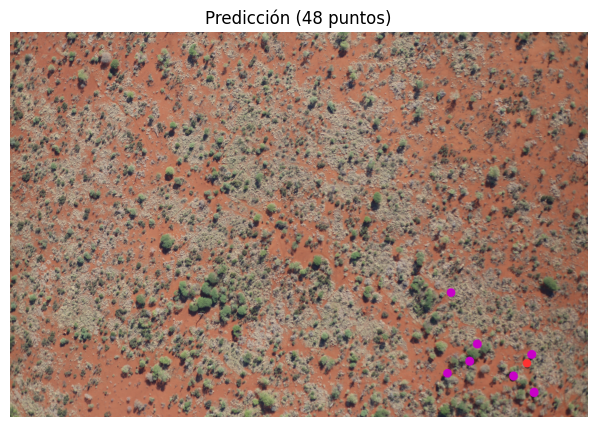

In [ ]:
from PIL import Image

image_path = "sample.JPG"

pil_image = Image.open(image_path).convert("RGB")

json_result = predictImage(pil_image)